#  This chapter covers
Computing the training and validation set losses 
to assess the quality of LLM-generated text 
during training

Implementing a training function and pretraining 
the LLM

Saving and loading model weights to continue 
training an LLM

Loading pretrained weights from OpenAI

In [2]:
import torch
from build_llm_utils import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,   # We shorten the context length from 1,024 to 256 tokens.
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12, 
    "drop_rate": 0.1,      
    "qkv_bias": False
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

In [3]:
import tiktoken
from build_llm_utils import generate_text_simple
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # .unsqueeze(0) adds the batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0)     # Removes batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


### Calculating the text generation loss

In [4]:
#  two input examples for the GPT model ("every effort moves" and "I really like")
inputs = torch.tensor([[16833, 3626, 6100],     # ["every effort moves",
                        [40,    1107, 588]])    #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107, 588, 11311]])  #  " really like chocolate"]

In [5]:
# feed the inputs into the model to calculate logits vectors
with torch.no_grad():    
    logits = model(inputs)
probas = torch.softmax(logits, dim=-1)    
print(probas.shape)

torch.Size([2, 3, 50257])


In [6]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("Token IDs:\n", token_ids)

Token IDs:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


In [7]:
print(f"Targets batch 1: {token_ids_to_text(targets[0], tokenizer)}")
print(f"Outputs batch 1:"
      f"{token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

#  it has not been trained yet

Targets batch 1:  effort moves you
Outputs batch 1: Armed heNetflix


In [8]:
# print the initial softmax probability scores
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]] # [batch, tokens, embeddings]
print("Text 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("Text 2:", target_probas_2)

Text 1: tensor([7.4541e-05, 3.1061e-05, 1.1563e-05])
Text 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


In [9]:
# calculate the loss for the probability scores of the two example batches
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

# During training the model first outputs logits, which are then converted to probability distributions by softmax (or other methods), and then the probabilities corresponding to the correct targets are extracted. Taking the logarithm of these probabilities, and then taking the negative mean, we get the negative log likelihood loss (NLL loss), and the goal of training is to minimize this loss so that the model assigns a higher probability to the correct target

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])
tensor(-10.7940)
tensor(10.7940)


In [10]:
print("Logits shape:", logits.shape)
print("Targets shape:", targets.shape)

Logits shape: torch.Size([2, 3, 50257])
Targets shape: torch.Size([2, 3])


In [11]:
# For the cross_entropy loss function in PyTorch, we want to flatten these tensors
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()
print("Flattened logits:", logits_flat.shape)
print("Flattened targets:", targets_flat.shape)

Flattened logits: torch.Size([6, 50257])
Flattened targets: torch.Size([6])


In [12]:
# targets_flat is the index of target logits_flat's token we want to calculate loss
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

tensor(10.7940)


Perplexity can be calculated as perplexity = torch.exp(loss), which returns
tensor(48725.8203) when applied to the previously calculated loss. 
Perplexity is often considered more interpretable than the raw loss value because it sig
nifies the effective vocabulary size about which the model is uncertain at each step. In
the given example, this would translate to the model being unsure about which among
48,725 tokens in the vocabulary to generate as the next token.

In [13]:
# Perplexity
print(torch.exp(loss))

tensor(48725.8203)


### Use the-verdict.txt to train model

In [14]:
file_path = "../the-verdict.txt"
with open(file_path, "r", encoding="utf-8") as file:
    text_data = file.read()

In [15]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))
print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


In [16]:
# define a train_ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


In [17]:
# create dataloader
from build_llm_utils import create_dataloader_v1
torch.manual_seed(123)
train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)
val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [18]:
# iterate through the data loaders to ensure that theywere created correctly
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)
    
print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


In [19]:
# implement a utility function to calculate the cross entropy loss for one batch
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device)        
    target_batch = target_batch.to(device)      
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1), target_batch.flatten()
    )
    return loss

###  Function to compute the training and validation loss for Dataloader

In [21]:
# computes the loss over all the batches sampled by a given data loader
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader) # Iteratives over all batches if no fixed num_batches is specified
    else:
        num_batches = min(num_batches, len(data_loader))  

    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

In [22]:
# see this calc_loss_loader function in action
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  
with torch.no_grad():                                       
    train_loss = calc_loss_loader(train_loader, model, device)   
    val_loss = calc_loss_loader(val_loader, model, device)
print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.987583266364204
Validation loss: 10.98110580444336


### Finally! Train a LLM
8 steps for training a LLM:
1. Iterate over training epochs
2. Iterate over batches in each training epoch
3. Reset loss gradients from previous batch iteration
4. Calculate loss on current batch
5. Backward pass to calculate loss gradients
6. Update model weights using loss gradients
7. Print training and validation set losses
8. Generate sample text for visual inspection

### The main function for pretraining LLMs

In [ ]:
def train_model_simple(model, train_loader, val_loader,
               optimizer, device, num_epochs,
               eval_freq, eval_iter, start_context, tokenizer):
    #  Initializes lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []   
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):   
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  
            loss = calc_loss_batch(
                input_batch, target_batch, model, device
            )
            loss.backward()                    
            optimizer.step()                   
            tokens_seen += input_batch.numel()
            global_step += 1

            if global_step % eval_freq == 0:   
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                    f"Train loss {train_loss:.3f}, "
                    f"Val loss {val_loss:.3f}"
                )
        
        generate_and_print_sample(                     
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval() 
    with torch.no_grad():
        train_loss = calc_loss_loader(
            train_loader, model, device, num_batches=eval_iter
        )
        val_loss = calc_loss_loader(
            val_loader, model, device, num_batches=eval_iter
        )
    model.train()
    return train_loss, val_loss

# Using the trained model, generate a new piece of text based on the starting text start_context, and print it out
def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))     
    model.train()

Training a GPTModel instance for 10 epochs using an
AdamW optimizer and the train_model_simple function

In [25]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=0.0004, weight_decay=0.1
)
num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.817, Val loss 9.928
Ep 1 (Step 000005): Train loss 8.067, Val loss 8.334
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.624, Val loss 7.051
Ep 2 (Step 000015): Train loss 6.049, Val loss 6.603
Every effort moves you, the,, and,,,,,,, and,.                                   
Ep 3 (Step 000020): Train loss 5.549, Val loss 6.501
Ep 3 (Step 000025): Train loss 5.413, Val loss 6.366
Every effort moves you, and to the of the of the of the, and I had. Gis, and, and, and, and, and, and I had, and, and, and, and, and, and, and, and, and,
Ep 4 (Step 000030): Train loss 4.912, Val loss 6.283
Ep 4 (Step 000035): Train loss 4.665, Val loss 6.310
Every effort moves you of the picture.                        "I"IHe the picture"I"I           
Ep 5 (Step 000040): Train loss 3.966, Val loss 6.152
Every effort moves you know the                          "Oh, and his pictures a, and he said.          
Ep 6 (Step 00

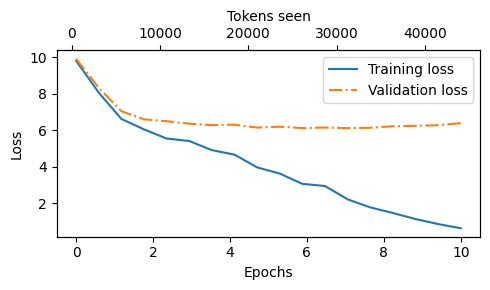

In [ ]:
# create a simple plot that shows the training and validation set losses side by side
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(
        epochs_seen, val_losses, linestyle="-.", label="Validation loss"
    )
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()                  
    ax2.plot(tokens_seen, train_losses, alpha=0)    
    ax2.set_xlabel("Tokens seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

# it’s overfitting

###  Decoding strategies to control randomness
temperature scaling and top-k sampling

In [27]:
# plug the GPTModel instance (model) into the generate_text_simple function,
# which uses the LLM to generate one token at a time

model.to("cpu")
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you?"

"Yes--quite insensible to the irony. She wanted him vindicated--and by me!"




###  Temperature scaling